# Generative model for MOT images
## Team: Loic Anderegg, Daniel Ang, Andrei Gheorghe

The high level objective of this project is to get the temperature of a gas of molecules or atoms trapped in a magneto-optical trap (MOT). For this, the first goal is to fit images of the MOT taken on a CCD camera to 2D Gaussians, which is our basic guess for its shape. On top of shape we also model multiple sources of uncertainty, from statistical uncertainty in our 2D Gaussian guess to uncertainties arising from shot noise, readout noise or scattered light noise. 

To actually get the temperature of the gas we physically have to release the molecules/atoms from the trap and let them expand. From the expansion rate we can then infer the temeprature. Thus, the second goal is to analyze multiple such images taken at different times after the release from the trap. For each moment in time we use our model to fit parameters such as $\sigma_{\mathrm{x}}$ and $\sigma_{\mathrm{y}}$, i.e. the widths of the MOT, which we then use to obtain the temperature.

Ideally the package should be flexible enough to be used on any MOT image. Members from our group have data for MOTs made from molecules of CaF, or from atoms of Rb or K. We build our package by first testing it on the molecular MOT, since that is the one with the lowesr SNR and it also lends itself to expansions of the model such as considering the slosh of particles in the trap itself, which is not negligible in this case (in other words all trapped molecules have a non negligible initial velocity in the same direction).

In [1]:
%matplotlib inline 

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import math

import pandas as pd
import seaborn as sns

import emcee

import csv

from io_package import *
from params_MOT import MOT_image

### Bare model

The model is represented by a 2D Gaussian, with random peak amplitude, width and peak position.

We thus start by defining the 2D and 1D Gaussian function:

In [2]:
def gaussian_2d(x, y, center_x, center_y, amplitude, sigma_x, sigma_y):
    return amplitude*np.exp(-(x-center_x)/(2*sigma_x**2))*np.exp(-(y-center_y)/(2*sigma_y**2))

def gaussian_1d(z, center_z, sigma_z, amplitude):
    return amplitude*np.exp(-(z-center_z)**2/(2*sigma_z**2))

We next define the model:

In [3]:
def Image_with_CCD_readout_charge(image, readout_charge):
    charge=(np.cumsum(image[::-1],axis=0)/readout_charge)
    return image + charge[::-1]

def MOT_bare_model(x, y, theta):
    center_x, center_y, amplitude, sigma_x, sigma_y, background_offset, sigma_m, sigma_g = theta
    return gaussian_2d(x, y, center_x, center_y, amplitude, sigma_x, sigma_y) + background_offset

def MOT_model(x, y, theta):
    # Use 40 for the readout_charge for now
    return Image_with_CCD_readout_charge(MOT_bare_model(x, y, theta), 40)


For an example of how a generic image generated with this model looks like, look at model_MOTonly.ipynb file.

### Uncertainties

We consider three possible uncertainty sources:

- a Gaussian statistical uncertainty in the model, $\epsilon_{\mathrm{i}}$;
- a Poissonian uncertainty, given by shot noise in the CCD camera;
- a Poissonian uncertainty, given by scattered light;
- a Gaussian uncertainty with a prior that is proportionally higher if the pixels below it are brighter.

## Likelihood function

To construct the likelihood function we need to consider all the uncertainties. Thus, each data point is given by: 

$$y_{\mathrm{i}} = z_{\mathrm{i}} + e_{\mathrm{i}} = m(x_{\mathrm{i}}, \theta) + \epsilon_{\mathrm{i}} + f_{\mathrm{i}} + g_{\mathrm{i}} + sct_{\mathrm{i}},$$

where $m(x_{\mathrm{i}}, \theta)$ is the model data and $\theta$ the set of parameters that go into the data.

Following the methods of Gregory 4.8, we have the probability distribution for the proposition $Z_i$ that the model we considered gives for the $i$-th data point values in the range $z_{\mathrm{i}}$ to $z_{\mathrm{i}} + dz_{\mathrm{i}}$:

$$p(Z_{\mathrm{i}}|M, \theta, I) = f_{\mathrm{Z}}(z_{\mathrm{i}}) = \frac{1}{\sqrt{2 \pi}\sigma_{\mathrm{mi}}} exp \left( \frac{- \epsilon_i}{2 \sigma_{\mathrm{mi}}} \right)$$.

Note that for simplicity we will consider $\epsilon_{\mathrm{i}} = \epsilon$ and $\sigma_{\mathrm{mi}} = \sigma_{\mathrm{m}}$, for all $i$.

Next the shot noise component is given by:

$$p(F_{\mathrm{i}}|M, \theta, I)  = e^{-\mu_fi} \frac{\mu_{\mathrm{fi}}^n}{n!}.$$

A similar expression applies to the scattered light noise, with expected photon number $\mu_{\mathrm{scti}}$.

Finally, include the readout noise. For now, only consider it as a simple Gaussian but can easily add a prior of the form sum(z(x0, y-i)), for $i$ from $0$ to $y0$, where (x0, y0) are the coordiantes of the pixel we are analyzing. Then the noise is really this Gaussian likelihood times the prior.

$$p(G_{\mathrm{i}}|M, \theta, I) = \frac{1}{\sqrt{2 \pi}\sigma_{\mathrm{gi}}} exp \left( \frac{- g_i}{2 \sigma_{\mathrm{gi}}} \right)$$

The likelihood for each pixel is then the convolution of the noise sources and the total likelihood is the product of all likelihoods for each pixel (so for log of the likelihood we perform a sum). For the first stages of the project we perform the convolution directly:

NOTE: In this simple version of the model, the two Gaussian uncertainties convolve to a Gaussian with $\sigma = \sigma_{\mathrm{m}} + \sigma_{\mathrm{g}}$

In [39]:
def log_likelihood(theta, x, y, data):
    '''
    x, y: independent data (arrays of size 50)
    data: measurements (brightness of pixel) 
    sigma_m: uncertainty in the model chosen
    sigma_g: uncertainty from scattered light background
    theta: model parameters
    '''
    center_x, center_y, amplitude, sigma_x, sigma_y, background_offset, sigma_m, sigma_g = theta
      
    #return -0.5*(np.sum((data[x-1][y-1] - MOT_model(x, y, theta))**2/(sigma_m**2 + sigma_g**2) + np.log(sigma_m**2 + sigma_g**2)))
    for i in x:
        for j in y:
            return -0.5*(np.sum((data[int(i)-1][int(j)-1] - MOT_model(x, y, theta))**2/(sigma_m**2 + sigma_g**2) + np.log(sigma_m**2 + sigma_g**2)))
    
def log_prior(theta):
    """
    returns log of prior probability distribution
    
    Parameters:
        theta: model parameters (specified as a tuple)
    """
    # unpack the model parameters
    center_x, center_y, amplitude, sigma_x, sigma_y, background_offset, sigma_m, sigma_g = theta
  
    # impose bounds on parameters
    # For now (the model data) impose strong bounds
    if center_x > 30 or center_x < 20:
        return -math.inf
    if center_y > 30 or center_y < 20:
        return -math.inf
    if amplitude > 450 or amplitude < 350:
        return -math.inf
    if sigma_x > 8 or sigma_x < 5:
        return -math.inf
    if sigma_y > 8 or sigma_y < 3:
        return -math.inf
    if sigma_m < 0: 
        return -math.inf
    if sigma_g < 0:
        return -math.inf
    if background_offset > 1000:
        return -math.inf
    
    sigma_sigma_m_Jeff_prior = 1/(sigma_m) 
    sigma_sigma_g_Jeff_prior = 1/(sigma_g)
 
    sigma_x_prior = 100/(50/7.5 - sigma_x)**2
    sigma_y_prior = 100/(50/9 - sigma_y)**2
    
    # Use a pretty strong prior on the sigma_x and sigma_y values (for now)
    if math.isnan(sigma_x_prior) or math.isnan(sigma_y_prior):
        return 0 + np.log(sigma_sigma_m_Jeff_prior) + np.log(sigma_sigma_g_Jeff_prior)
    else:
        return 0 + np.log(sigma_sigma_m_Jeff_prior) + np.log(sigma_sigma_g_Jeff_prior) + np.log(sigma_x_prior) + np.log(sigma_y_prior)
    
def log_posterior(theta, x, y, data):
    '''
    theta: model parameters
    x, y: independent data (arrays of size 250)
    z: measurement (brightness of pixel) 
    sigma_m: uncertainty in the model chosen
    sigma_g: uncertainty from scattered light background
    theta: model parameter
    '''
    
    center_x, center_y, amplitude, sigma_x, sigma_y, background_offset, sigma_m, sigma_g = theta
    
    return log_prior(theta) + log_likelihood(theta, x, y, data)

In [40]:
def sampler (data, ndim, nwalkers, nsteps):
    
    # Set up the data
    x = np.linspace(1, image_size, image_size)
    y = np.linspace(1, image_size, image_size)
    
    ndim = ndim
    nwalkers = nwalkers
    nsteps = nsteps

    #initial guess for center_x, center_y, amplitude, sigma_x, sigma_y, background_offset, sigma_m, sigma_g
    ls_result = [25, 25, 400, 6.6667, 5.5556, 100, 20, 20] # from HBL figure 1 and randomly guessing
    
    starting_positions = [ls_result + 1e-1*np.random.randn(ndim) for i in range(nwalkers)]
    
    # set up the sampler object
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x, y, data))
    
    # run the sampler. We use iPython's %time directive to tell us 
    # how long it took (in a script, you would leave out "%time")
    %time sampler.run_mcmc(starting_positions, nsteps)
    print('Done')
    
    return sampler

### Load sample data:

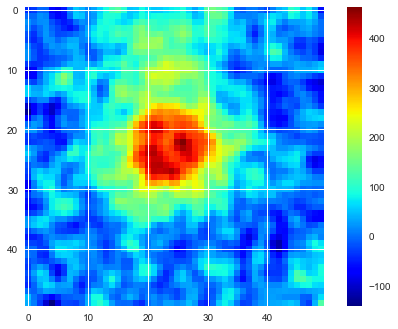

In [41]:
model_data_path = get_data_file_path('model_data.csv')
model_data = load_data(data_file = model_data_path, delim = ' ')

image_size = 50 

image_object = load_image(model_data)

# Try method of the class
image_object.show(gauss_filter = True)

In [42]:
emcce_sample = sampler (model_data, 8, 50, 2000)

Wall time: 5.12 s
Done


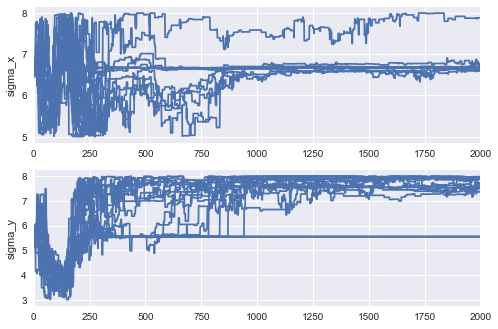

In [43]:
#initial guess for center_x, center_y, amplitude, sigma_x, sigma_y, background_offset, sigma_m, sigma_g

fig, (ax_sigma_x, ax_sigma_y) = plt.subplots(2)
ax_sigma_x.set(ylabel='sigma_x')
ax_sigma_y.set(ylabel='sigma_y')
for i in range(20):
    sns.tsplot(emcce_sample.chain[i,:,3], ax=ax_sigma_x)
    sns.tsplot(emcce_sample.chain[i,:,4], ax=ax_sigma_y)


In [44]:
# Throw away first 1000 steps
ndim = 8

samples = emcce_sample.chain[:,1000:,:]
traces = samples.reshape(-1, ndim).T

parameter_samples = pd.DataFrame({'sigma_x': traces[3], 'sigma_y': traces[4]})

q = parameter_samples.quantile([0.16,0.50,0.84], axis=0)
sigma_x = q['sigma_x'][0.50]
sigma_y = q['sigma_y'][0.50]

In [45]:
q

,sigma_x,sigma_y
0.16,6.665938,7.262781
0.50,6.666667,7.789465
0.84,6.668797,7.952586


(With the extremely trong priors) the fit is reasonable...